## Image Impeccable: Journey to Clarity
*https://thinkonward.com/app/c/challenges/image-impeccable*  
*Solution for the 8th place (0.984671)*  
*Copyright (c) 2024 Igor Ivanov*  
*License: MIT*  

## Contents

1. Approach
2. Hardware requirements and Time
3. Software requirements and Installation
4. Inference
5. Training
6. Analysis and Visualization

## 1. Approach

#### 1.1 Summary

For this challenge I trained the 2D Unet model with `EfficientNet-B0` encoder using [segmentation_model_pytorch](https://github.com/qubvel/segmentation_models.pytorch) framework which allows to easily adapt standard Unet architecture for denoising task. Specifically we just need to set the number of output classes to 1 and change activation of the last layer to `sigmoid` in order to have output in the range `[0, 1]`. As training data I used volume slices over axis 0 and axis 1 (i.e. 1-channel images of size 300 x 1259). I used `torch.nn.L1Loss()` (MAE) and Adam optimizer. The following hyperparameters turned out to be the best in my experiments: batch 28, learning rate 1e-3, 10 epochs, `ReduceLROnPlateau` schedule, mixed precision training. Model was trained using a 5-fold split to ensure robust solution, so there are 5 checkpoints in total. Folds were created based on `GroupKFold` on the volume level i.e. validation is performed on completely unseen volumes. As a final ensemble I averaged predictions from 5 checkpoints (folds) and 2 axes. All mentions of axis indices (axis 0, axis 1, axis 2) are based on the volume shape of `(300, 300, 1259)`. As a training data I used 240 volumes out of 249 total because 9 volumes have mismatched labels (clean volumes).

#### 1.2 Details

I chose 2D Unet architecture and started my research from training 3 independent axis-specific models i.e. trained on slices taken from one of 3 axes and predicting the corresponding axis. In these initial experiments axes 0 and 1 gave comparable good scores around 0.97 (axis 1 was slightly better). Axis 2 (300 x 300 slices) gave a much lower score of 0.91 which is close to the case where we use original noisy images as prediction (0.90). This result suggested that axis 2 has very low signal, and the main direction for further experiments were axes 0 and 1. Then I tried to infer another axis which was not seen by the model (i.e. train on axis 0 and predict axis 1). Surprisingly scores for unseen axis were very good and in general comparable with the axis seen by the model. This fact leads to a conclusion that the noise has similar properties over both axes 0 and 1. At this point the logical idea was to train on images taken from both axes. This approach allows to utilize 2 times more images and serves as natural augmentation. There were 144k images in total (115k training, 29k validation). Models trained on joint data were significantly better than each of axis-specific models (around 0.98+). Next improvement came from predicting axis 0 and axis 1 and averaging the result.

I tried to use several different encoders. `EfficientNet-B0`, `EfficientNet-B3`, and `EfficientNet-B7` demonstrated comparable scores, `Mix Vision Transformer` (`mit_b0`) had lower scores. Given that larger encoders had no positive effect, we can conclude that possibly encoder is less important than decoder. I tried two losses based on absolute (`torch.nn.L1Loss()`) and squared (`torch.nn.MSELoss()`) error. Both give almost identical scores with other hyperparameters being equal.

Another interesting experiment I trained was the so-called 2.5D model. To create a single training example we stack five 1-channel images and use it as a single multichannel image. Model's output also has 5 channels. Middle slice of 5 total slices is the final prediction for any given example. Motivation for such a model is to give more context so the model can capture some "pseudo 3D" features. Local validation score of this model was lower compared to the 2D model, so I did not submit it and stopped experiments in this direction.

I tried longer training for 20 and 30 epochs with different learning rates (1e-3, 1e-4) and different batch sizes without improvement. Also I tried to create slices from a volume with a step. Specifically I took each 6th slice. This approach also did not improve the score meaning that all consecutive slices are useful for the model. As a promising post-processing I tried Gaussian filtering over the predicted volume using the function `scipy.ndimage.gaussian_filter(volume, sigma=1)`. This approach did not improve the score. Upon visual inspection of the slices there are some regions which seemingly have improvements (slightly less visible noise), but again the leaderboard score was lower. For my best final model I did not use augmentation but I used it when training other models on smaller data and it brought an improvement so adding augmentation to my final model could be beneficial.

#### 1.3 Notes

Given the large size of the dataset I did not include it in the solution package. Please see directory structure and installation section below to find out where to extract train and test data.  
During training the loss may have some fluctuations, so the training script will retain the checkpoint of 10th epoch in each fold regardless if it has the best loss.  
Scripts rely on the naming convention represented in train/test data to distinguish between noisy and clean volumes. Specifically it is expected that file names of nosy volumes contain `noise` substring and corresponding file names of clean volumes contain `RFC` substring.  

#### 1.4 Local validation scores

In the table below we can see that the LB score closely follows local validation scores.  
Ensembling (averaging) predictions over both axes consistently improves the score. The same effect was observed in the leaderboard.  
Scores for each fold were computed using the official `scoring` function based on predictions for 16 out-of-fold volumes i.e. similar size to the test data.  
Axis-specific column name means that during inference the model received only images taken from the specified axis.  
Leaderboard score of the ensemble of folds and axes is **0.9846**  

| Fold | Model name                | MAE loss | SSIM axis-0 | SSIM axis-1 | SSIM ensemble of 2 axes |
|------|---------------------------|----------|-------------|-------------|-------------------------|
| 0    | model-f0-e009-0.0283.bin  | 0.0283   | 0.9836      | 0.9805      | 0.9855                  |
| 1    | model-f1-e009-0.0306.bin  | 0.0306   | 0.9818      | 0.9831      | 0.9859                  |
| 2    | model-f2-e009-0.0255.bin  | 0.0255   | 0.9794      | 0.9799      | 0.9837                  |
| 3    | model-f3-e009-0.0307.bin  | 0.0307   | 0.9843      | 0.9846      | 0.9873                  |
| 4    | model-f4-e009-0.0287.bin  | 0.0287   | 0.9841      | 0.9820      | 0.9867                  |
|      |                           |          |             |             |                         |
| avg  |                           | 0.0288   | 0.9826      | 0.9820      | 0.9858                  |


**Directory structure:**
```
solution
|
|-- models
|
|-- test
|   |-- 2024-06-10_0d6402b1
|   |-- 2024-06-10_1a4e5680
|   |-- ...
|
|-- train
|   |-- 42487393
|   |-- 42487919
|   |-- ...
|
|-- create_images.py
|-- infer.py
|-- LICENSE.txt
|-- requirements.txt
|-- solution.ipynb
|-- train.py
|-- utils.py
```

## 2. Hardware requirements and Time

Hardware:

* 8x CPU
* 32 GB RAM
* 1x L4-24GB GPU
* 500 GB SSD

Time:

* Training data creation: **2 hours**  
* Training time:          **60 hours**  
* Test data creation: **5 minutes**
* Inference time:     **10 minutes**

## 3. Software requirements and Installation

* Ubuntu 20.04
* Python: 3.10.12 (Conda)
* CUDA 12.1

**Dataset setup**  

Solution package has empty `train` and `test` dirs. Please extract train and/or test data in corresponding locations so that we have default dir structure outlined in the section 1 above. Also you can just point the `--input_dir` parameter of the scripts to any data location.

In [1]:
%cd ~/solution
!pip install -r requirements.txt

/home/userubd/solution


/home/userubd/miniconda3/envs/py31012prev/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/userubd/miniconda3/envs/py31012prev/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121


## 4. Inference

#### 4.1 Create test data

Please replace `--input_dir` value with the path to the directory containing holdout volumes.  
Same structure is expected i.e. each `.npy` file resides inside its own subdirectory.  

In [2]:
!python create_images.py \
--input_dir=test \
--output_dir_axis_0=test_img_axis_0 \
--output_dir_axis_1=test_img_axis_1 \
--has_label=0

input_dir                 test
output_dir_axis_0         test_img_axis_0
output_dir_axis_1         test_img_axis_1
has_label                 0
n_volumes                 -1
N volumes: 15
Noisy volume: 000 of 15
Noisy volume: 001 of 15
Noisy volume: 002 of 15
Noisy volume: 003 of 15
Noisy volume: 004 of 15
Noisy volume: 005 of 15
Noisy volume: 006 of 15
Noisy volume: 007 of 15
Noisy volume: 008 of 15
Noisy volume: 009 of 15
Noisy volume: 010 of 15
Noisy volume: 011 of 15
Noisy volume: 012 of 15
Noisy volume: 013 of 15
Noisy volume: 014 of 15
Axis: 1    Image: 299
Done


#### 4.2 Run inference 

Input dirs in the following command are the output dirs created with `create_images.py` script on the previous step.

In [3]:
!python infer.py \
--input_dir_axis_0=test_img_axis_0 \
--input_dir_axis_1=test_img_axis_1 \
--model_dir=models \
--submission_path=submission.npz

input_dir_axis_0          test_img_axis_0
input_dir_axis_1          test_img_axis_1
encoder_name              timm-efficientnet-b0
encoder_weights           None
in_channels               1
classes                   1
model_dir                 models
submission_path           submission.npz
N dirs axis 0: 15
N dirs axis 1: 15
Loaded model: models/model-f0-e009-0.0283.bin
Loaded model: models/model-f1-e009-0.0306.bin
Loaded model: models/model-f2-e009-0.0255.bin
Loaded model: models/model-f3-e009-0.0307.bin
Loaded model: models/model-f4-e009-0.0287.bin
N models: 5


## 5. Training

#### 5.1 Create training data

In [4]:
!python create_images.py \
--input_dir=train \
--output_dir_axis_0=train_img_axis_0 \
--output_dir_axis_1=train_img_axis_1 \
--has_label=1

input_dir                 train
output_dir_axis_0         train_img_axis_0
output_dir_axis_1         train_img_axis_1
has_label                 1
n_volumes                 -1
N volumes: 240
Noisy volume: 000 of 240
Clean volume: 000 of 240
Noisy volume: 001 of 240
Clean volume: 001 of 240
Noisy volume: 002 of 240
Clean volume: 002 of 240
Noisy volume: 003 of 240
Clean volume: 003 of 240
Noisy volume: 004 of 240
Clean volume: 004 of 240
Noisy volume: 005 of 240
Clean volume: 005 of 240
^Cis: 0    Image: 077
Traceback (most recent call last):
  File "/home/userubd/miniconda3/envs/py31012prev/lib/python3.10/site-packages/PIL/ImageFile.py", line 536, in _save
    fh = fp.fileno()
AttributeError: '_idat' object has no attribute 'fileno'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/userubd/solution/create_images.py", line 111, in <module>
    process_volume(path, data_type='clean')
  File "/home/userubd/solution/create

#### 5.2 Run training

Model trained on images from both axes was the best in my experiments, but if you interested in axis-specific model, just set   
`--input_dir=train_img_axis_0` or `--input_dir=train_img_axis_1`.

Script will train 5 folds consequently. To train a single fold (e.g. fold 0) set `--initial_fold=0` and `--final_fold=1`.  

Each checkpoint contains all states (model, optimizer, etc.) so it is possible to continue training if there was an interruption. Please set the corresponding fold index (specified in checkpoint filename) and the last available checkpoint file. For example, if training was interrupted in the middle of fold-2 we need to set:  
`--initial_fold=2` and `--ckpt=checkpoints/model-f2-e005-0.2834.bin`. All other parameters remain the same.

In [5]:
!python train.py \
--input_dir=train_img_axis_* \
--output_dir=checkpoints \
--encoder_name=timm-efficientnet-b0 \
--in_channels=1 \
--classes=1 \
--n_epochs=10 \
--batch_size=28 \
--lr=0.001 \
--initial_fold=0 \
--final_fold=5

input_dir                 train_img_axis_*
output_dir                checkpoints
encoder_name              timm-efficientnet-b0
encoder_weights           imagenet
in_channels               1
classes                   1
n_epochs                  10
batch_size                28
lr                        0.001
num_workers               12
use_amp                   1
ckpt                      None
initial_fold              0
final_fold                5
reduce_p                  1
reduce_f                  0.5
reduce_mode               min
N volumes: 5
N images: 3000
N labels: 3000
Fold: 0
Init datasets...
Init model...
Starting from scratch...
Start training...
Epoch: 0
Batch: 0085    Loss: 0.0302    Time: 33
Eval: 0
Val batch: 0021    Val loss: 0.0121    Time: 36
Saved model: checkpoints/model-f0-e000-0.0121.bin
Epoch time 36 sec:
Epoch: 1
Batch: 0085    Loss: 0.0147    Time: 31
Eval: 1
Val batch: 0021    Val loss: 0.0104    Time: 34
Saved model: checkpoints/model-f0-e001-0.0104.bin
Epoch

## 6. Analysis and Visualization

We have 240 training volumes total. I.e in each fold we train on 192 volumes and validate on 48 volumes.  
The following table lists 16 out-of-fold volumes out of 48.  

| Fold | Model file               | Out-of-fold volumes
|------|--------------------------|-------------------------------------------------
| 0    | model-f0-e009-0.0283.bin | 42513046, 42623483, 42673700, 76125014, 76135802, 76153644, 76168819, 76180964, 77692228, 77694574, 77701360, 77701904, 77702180, 77702431, 77702838, 89203310
| 1    | model-f1-e009-0.0306.bin | 42503800, 42644874, 42673699, 76131837, 76135799, 76153540, 76164758, 76179455, 76193803, 77692440, 77701260, 77701801, 77702041, 77702428, 77702664, 89198377
| 2    | model-f2-e009-0.0255.bin | 42502775, 42582800, 42673697, 76123161, 76135600, 76152070, 76166706, 76178225, 77692225, 77692248, 77701298, 77701700, 77702117, 77702340, 77702735, 89194323
| 3    | model-f3-e009-0.0307.bin | 42487919, 42590535, 42673694, 76123888, 76134577, 76146613, 76165881, 76178741, 76194204, 77692253, 77701296, 77701795, 77702115, 77702426, 77702732, 89197054
| 4    | model-f4-e009-0.0287.bin | 42487393, 42587610, 42656169, 76123265, 76134271, 76145721, 76157187, 76178431, 76189561, 77692252, 77701191, 77701738, 77702111, 77702384, 77702635, 89194338

#### Direct vs. Indirect

Let’s analyze one interesting question arising from applying 2D models to 3D data. When we predict images taken over axis 0, what’s going on over axis 1 which is not seen by the model directly? Let’s find out. 

Recall that we have volumes of shape (300, 300, 1259). We train our model using slices from both axis 0 and axis 1 jointly. Then we predict test volume by giving to the model slices over axis 0 and stack all predicted slices over axis 0 to get full predicted (denoised) volume. Let’s say now we want to visualize our predictions. If we slice predicted volume over axis 0 we can see a "direct" prediction for axis 0 and this is obvious. But an interesting part is that we can also slice predicted volume over axis 1 and look at "indirect" prediction for axis 1. We call it indirect because the model did not produce it directly by processing noisy input slice taken over axis 1. In other words such patterns as "noise waves" are not seen if they spread over the orthogonal axis. The logic we described in relation to axis 0 is also applied to axis 1. So let's compare direct and indirect prediction by score and visually.

We will compute average scores from all slices of 16 volumes resulting in 4.8k images. It is worth mentioning that during training the model saw an equal number of slices over each axis.

We can see by the scores below that in general, direct and indirect scores are comparable for both axes, and the ensemble of axes is better than both components. It's interesting to note that while for axis 0 direct score is better (`0.983929` vs. `0.979657`) which seems to be expected, for axis 1 the opposite is true i.e. direct score is slightly lower (`0.981548` vs. `0.982842`). One possible conclusion is that the noise itself demonstrates different behavior over different axes.

Looking at the images below we can see that for given example noise is more visible on the indirect images `C` for both axes compared to direct and ensemble (`B` and `D`). But given that there is a variation between volumes and slices, numbers given above are more robust estimation of the effects compared to visuals.

As a general conclusion we can state that a 2D model can capture noise features even over an orthogonal axis.

### 6.1 Create OOF predictions

**Let's create `oof` dir and copy 16 out-of-fold volumes, process them, create predictions, and then analyze.**

In [6]:
!mkdir oof

!cp -r \
train/42513046 train/42623483 train/42673700 train/76125014 \
train/76135802 train/76153644 train/76168819 train/76180964 \
train/77692228 train/77694574 train/77701360 train/77701904 \
train/77702180 train/77702431 train/77702838 train/89203310 \
oof

**Create images (slices)**

In [7]:
!python create_images.py \
--input_dir=oof \
--output_dir_axis_0=oof_img_axis_0 \
--output_dir_axis_1=oof_img_axis_1 \
--has_label=1

input_dir                 oof
output_dir_axis_0         oof_img_axis_0
output_dir_axis_1         oof_img_axis_1
has_label                 1
n_volumes                 -1
N volumes: 16
Noisy volume: 000 of 16
Clean volume: 000 of 16
Noisy volume: 001 of 16
Clean volume: 001 of 16
Noisy volume: 002 of 16
Clean volume: 002 of 16
Noisy volume: 003 of 16
Clean volume: 003 of 16
Noisy volume: 004 of 16
Clean volume: 004 of 16
Noisy volume: 005 of 16
Clean volume: 005 of 16
Noisy volume: 006 of 16
Clean volume: 006 of 16
Noisy volume: 007 of 16
Clean volume: 007 of 16
Noisy volume: 008 of 16
Clean volume: 008 of 16
Noisy volume: 009 of 16
Clean volume: 009 of 16
Noisy volume: 010 of 16
Clean volume: 010 of 16
Noisy volume: 011 of 16
Clean volume: 011 of 16
Noisy volume: 012 of 16
Clean volume: 012 of 16
Noisy volume: 013 of 16
Clean volume: 013 of 16
Noisy volume: 014 of 16
Clean volume: 014 of 16
Noisy volume: 015 of 16
Clean volume: 015 of 16
Axis: 1    Image: 299
Done


**Load model and collect image dirs**

In [9]:
import os
import glob
import numpy as np
import torch
from PIL import Image
import segmentation_models_pytorch as smp
from infer import inference
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_file = 'models/model-f0-e009-0.0283.bin'
model = smp.Unet(encoder_name='timm-efficientnet-b0', encoder_weights=None, 
                 in_channels=1, classes=1, activation='sigmoid',)
model.to(device)
model.eval()
torch.set_grad_enabled(False)
model.load_state_dict(torch.load(model_file, map_location=device)['state_dict'])
print('Loaded model:', model_file)

# Collect image dirs
dirs_axis_0 = sorted(glob.glob('oof_img_axis_0/*/'))
dirs_axis_1 = sorted(glob.glob('oof_img_axis_1/*/'))

Loaded model: models/model-f0-e009-0.0283.bin


**Run inference**

In [10]:
prediction, names = inference(dirs_axis_0, dirs_axis_1, [model], device)

**Collect predicted volumes**

In [11]:
denoised_volumes = [[], [], []]
for i in range(len(prediction[0])): # 5
    volume_from_axis_0 = (prediction[0][i] * 255).astype(np.uint8)
    volume_from_axis_1 = (prediction[1][i] * 255).astype(np.uint8)
    volume_from_ensemble = (((prediction[0][i] + prediction[1][i]) / 2) * 255).astype(np.uint8)
    #   
    denoised_volumes[0].append(volume_from_axis_0)
    denoised_volumes[1].append(volume_from_axis_1)
    denoised_volumes[2].append(volume_from_ensemble)
    #
    print(i, end='\r')

**Compute SSIM scores for direct and indirect predictions**

In [12]:
volume_names = [d.split('/')[-2] for d in dirs_axis_0]

axis_0_direct_scores = []
axis_0_indirect_scores = []
axis_0_ens_scores = []

axis_1_direct_scores = []
axis_1_indirect_scores = []
axis_1_ens_scores = []

for j in range(len(volume_names)):
    volume_name = volume_names[j]    
    for i in range(300):
        #
        clean_slice_axis_0 = np.array(
            Image.open('oof_img_axis_0/%s/img_%s_%03d_clean.png' % (volume_name, volume_name, i)))
        #
        direct_pred_axis_0   = denoised_volumes[0][j][i, :, :]
        indirect_pred_axis_0 = denoised_volumes[1][j][i, :, :]
        ens_pred_axis_0      = denoised_volumes[2][j][i, :, :]
        #
        axis_0_direct_scores.append(ssim(clean_slice_axis_0, direct_pred_axis_0))
        axis_0_indirect_scores.append(ssim(clean_slice_axis_0, indirect_pred_axis_0))
        axis_0_ens_scores.append(ssim(clean_slice_axis_0, ens_pred_axis_0))
        #
        #
        clean_slice_axis_1 = np.array(
            Image.open('oof_img_axis_1/%s/img_%s_%03d_clean.png' % (volume_name, volume_name, i)))
        #
        direct_pred_axis_1   = denoised_volumes[1][j][:, i, :] # swapped: direct here is axis 1
        indirect_pred_axis_1 = denoised_volumes[0][j][:, i, :]
        ens_pred_axis_1      = denoised_volumes[2][j][:, i, :]
        #
        axis_1_direct_scores.append(ssim(clean_slice_axis_1, direct_pred_axis_1))
        axis_1_indirect_scores.append(ssim(clean_slice_axis_1, indirect_pred_axis_1))
        axis_1_ens_scores.append(ssim(clean_slice_axis_1, ens_pred_axis_1))
        #
        print('Volume: %03d    Image: %03d' % (j, i), end='\r')

In [13]:
print('Axis 0. Direct:   %.6f' % np.mean(axis_0_direct_scores))
print('Axis 0. Indirect: %.6f' % np.mean(axis_0_indirect_scores))
print('Axis 0. Ensemble: %.6f' % np.mean(axis_0_ens_scores))

Axis 0. Direct:   0.983929
Axis 0. Indirect: 0.979657
Axis 0. Ensemble: 0.985278


In [14]:
print('Axis 1. Direct:   %.6f' % np.mean(axis_1_direct_scores))
print('Axis 1. Indirect: %.6f' % np.mean(axis_1_indirect_scores))
print('Axis 1. Ensemble: %.6f' % np.mean(axis_1_ens_scores))

Axis 1. Direct:   0.981548
Axis 1. Indirect: 0.982842
Axis 1. Ensemble: 0.985536


### 6.2 Visualize

Arbitrary volume and slice

In [17]:
volume_id = 11  # 0 to 15
volume_name = volume_names[volume_id]
image_id = 33   # 0 to 299

### AXIS 0

**A) Axis 0. Original noisy slice**

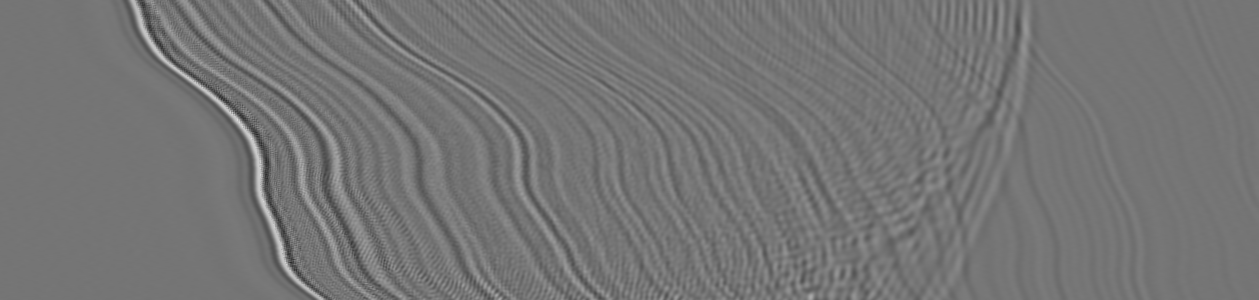

In [19]:
Image.open('oof_img_axis_0/%s/img_%s_%03d_noisy.png' % (volume_name, volume_name, image_id))

**B) Axis 0. Direct prediction**

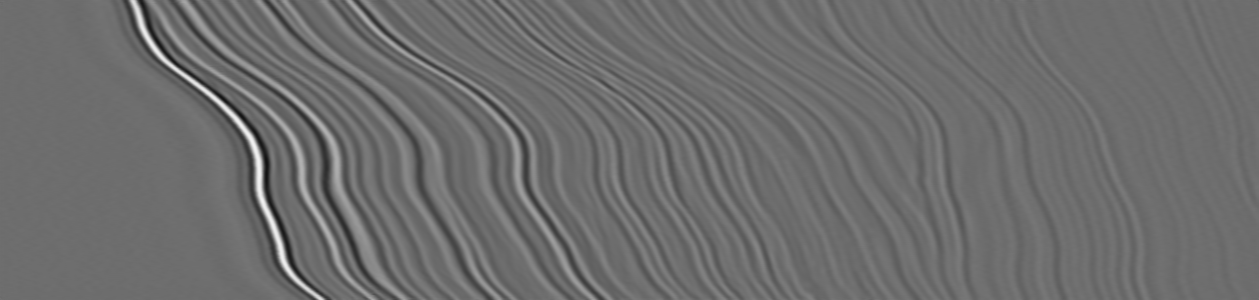

In [20]:
Image.fromarray(denoised_volumes[0][volume_id][image_id, :, :])

**C) Axis 0. Indirect prediction**

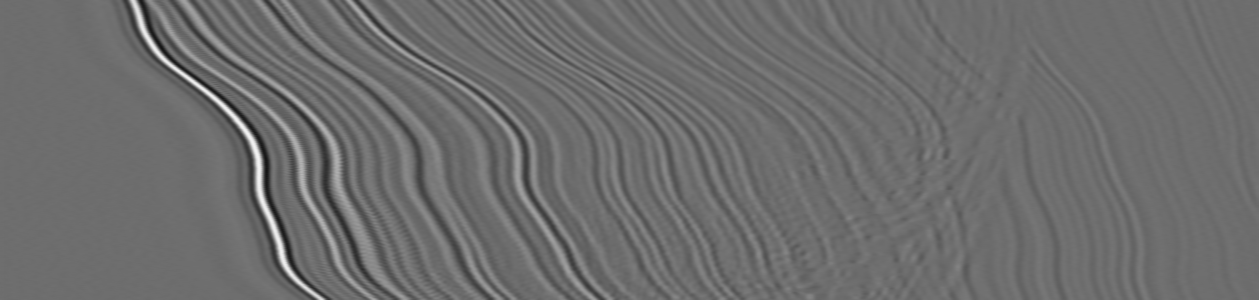

In [21]:
Image.fromarray(denoised_volumes[1][volume_id][image_id, :, :])

**D) Axis 0. Ensemble**

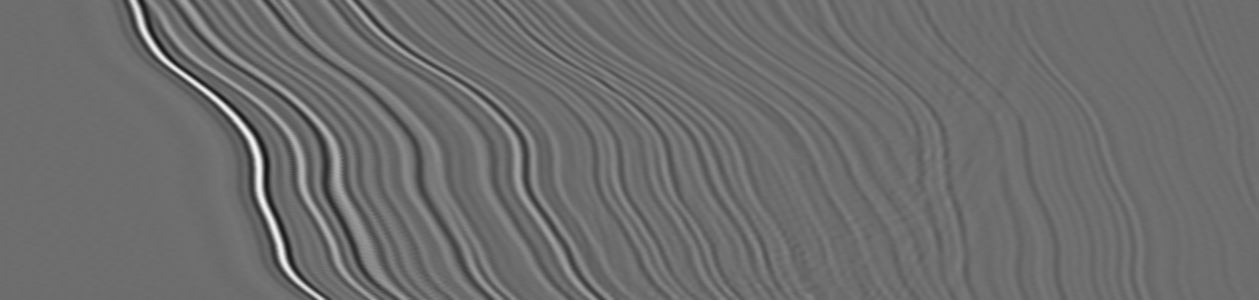

In [22]:
Image.fromarray(denoised_volumes[2][volume_id][image_id, :, :])

## AXIS 1

**A) Axis 1. Original noisy slice**

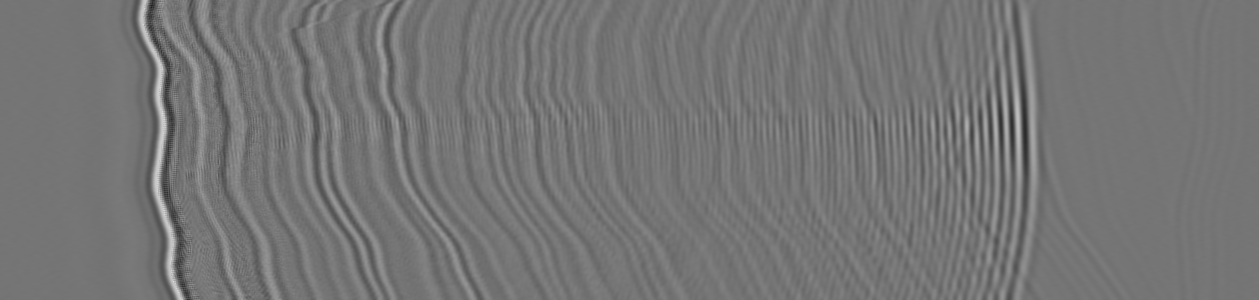

In [23]:
Image.open('oof_img_axis_1/%s/img_%s_%03d_noisy.png' % (volume_name, volume_name, image_id))

**B) Axis 1. Direct prediction**

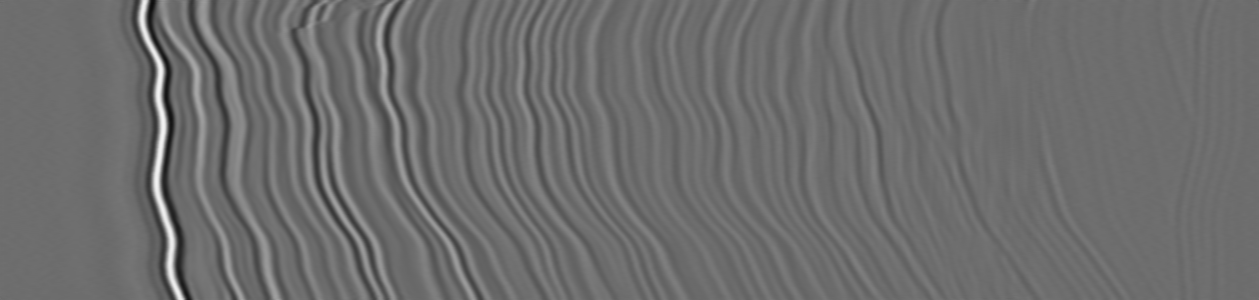

In [24]:
Image.fromarray(denoised_volumes[1][volume_id][:, image_id, :])

**C) Axis 1. Indirect prediction**

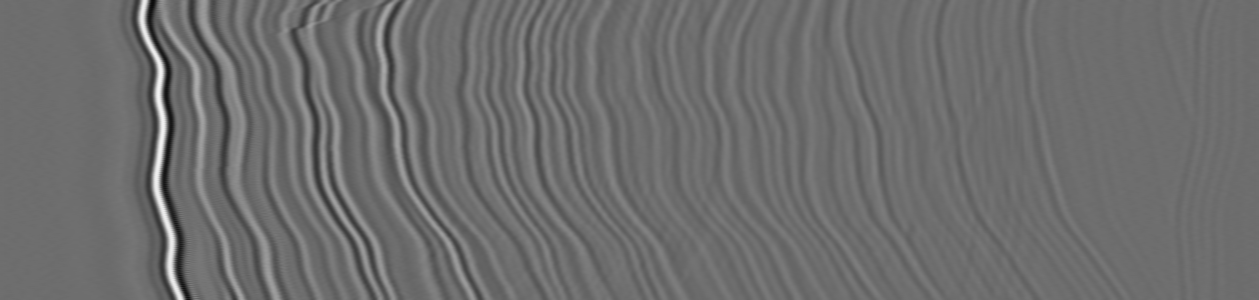

In [25]:
Image.fromarray(denoised_volumes[0][volume_id][:, image_id, :])

**D) Axis 1. Ensemble**

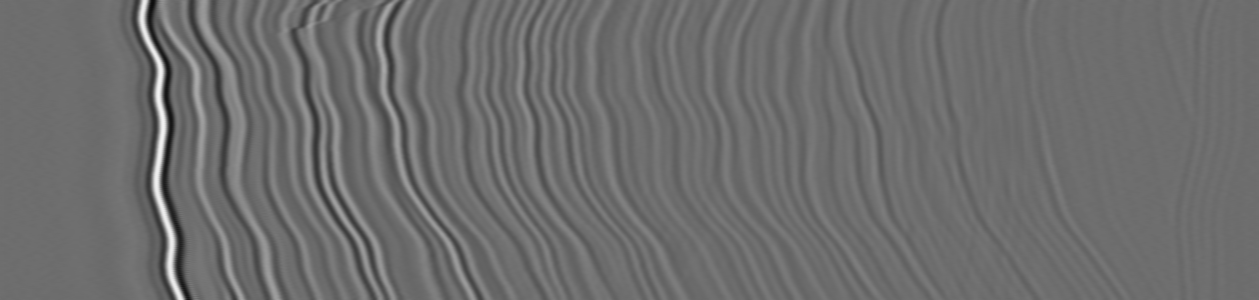

In [26]:
Image.fromarray(denoised_volumes[2][volume_id][:, image_id, :])

## 6.3 Gaussinal filtering

Let's take ensemble prediction where some slight noise is visible and try to improve it with a Gaussian filter. For the naked eye post-processed (bottom) image may appear slightly better in some regions, but the score is lower.

In [31]:
volume_id = 11  # 0 to 15
volume_name = volume_names[volume_id]
image_id = 33   # 0 to 299

true = np.array(Image.open('oof_img_axis_0/%s/img_%s_%03d_clean.png' % (volume_name, volume_name, image_id)))
pred = denoised_volumes[2][volume_id][image_id, :, :]
pred_gauss = gaussian_filter(denoised_volumes[2][volume_id], sigma=1)[image_id, :, :]

print('Original prediction:       %.6f' % ssim(true, pred))
print('Same with Gaussian filter: %.6f' % ssim(true, pred_gauss))

Original prediction:       0.981346
Same with Gaussian filter: 0.973328


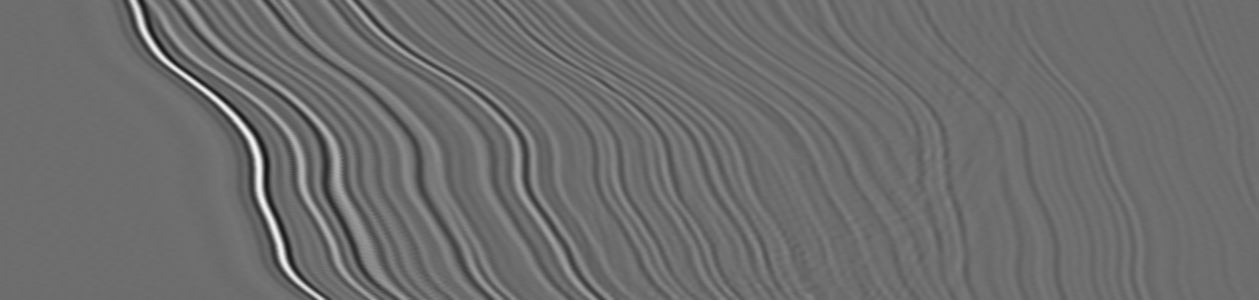

In [32]:
Image.fromarray(pred)

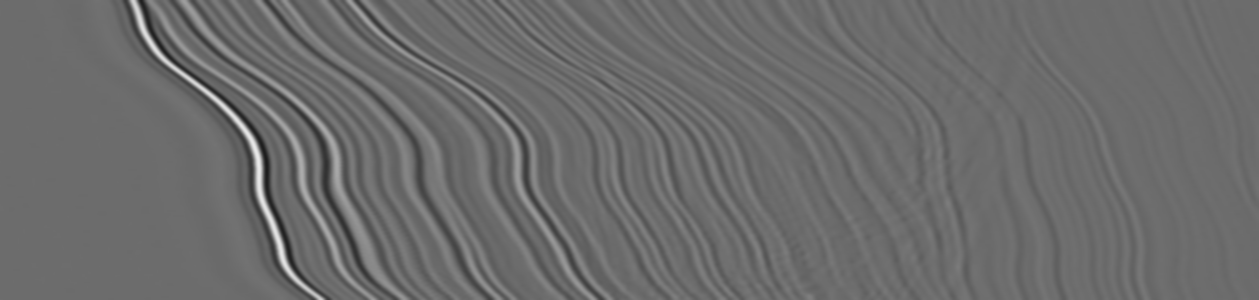

In [33]:
Image.fromarray(pred_gauss)

In [25]:
# END